In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB4
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os
import matplotlib.pyplot as plt
import random
# encode both columns label and variety
from sklearn.preprocessing import LabelEncoder
# ignore warnings   
import warnings
warnings.filterwarnings('ignore')

2024-05-28 14:48:34.154738: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 14:48:34.154839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 14:48:34.240912: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/pumpkin-leaf-v2/Pumpkin Leaf Dataset.v1i.folder/train',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,
    subset="training",
    seed=123
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/pumpkin-leaf-v2/Pumpkin Leaf Dataset.v1i.folder/valid',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,
    subset="validation",
    seed=123
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/pumpkin-leaf-v2/Pumpkin Leaf Dataset.v1i.folder/test',
    batch_size=32,
    image_size=(224, 224),
    label_mode=None,
    shuffle=False
)

Found 4200 files belonging to 5 classes.
Using 3360 files for training.
Found 399 files belonging to 5 classes.
Using 79 files for validation.
Found 200 files.


In [3]:
def visualize_images(path, num_images=5):

    # Get a list of image filenames
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    # Select random images
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, image_filename in enumerate(selected_images):
        # Load image
        image_path = os.path.join(path, image_filename)
        image = plt.imread(image_path)

        # Display image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

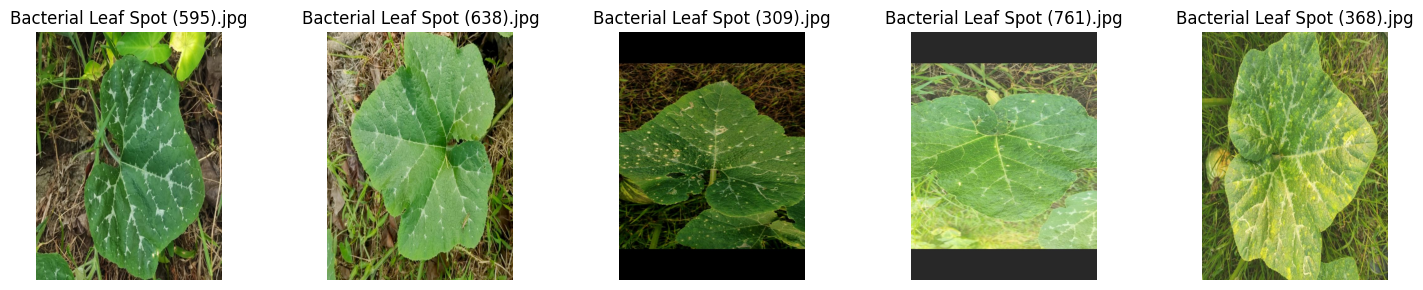

In [4]:
#Specify the path containing the images to visualize
path_to_visualize = '/kaggle/input/pumpkin-leaf-v2/Pumpkin Leaf Dataset.v1i.folder/train/Bacterial Leaf Spot'

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

In [5]:
# Retrieve class names
class_names = train_ds.class_names

# Print the class indices
print("Class indices for training generator:", class_names)


Class indices for training generator: ['Bacterial Leaf Spot', 'Downy Mildew', 'Healthy Leaf', 'Mosaic Disease', 'Powdery_Mildew']


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# Load the pre-trained EfficientNetB4 model without the top classification layer
efficientnet_base = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained base model layers
efficientnet_base.trainable = False


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [21]:
# Load the EfficientNetB0 model pre-trained on ImageNet without the top classification layer
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build the model
model = Sequential()

# Add the pre-trained EfficientNet base
model.add(efficientnet_base)

# Add global average pooling layer to reduce spatial dimensions
model.add(AveragePooling2D(pool_size=(7, 7)))  # Adjust pool size to match your input dimensions

# Flatten the feature maps
model.add(Flatten())

# Add a dense layer with 220 units and ReLU activation function
model.add(Dense(220, activation='relu'))

# Dropout Layer
model.add(Dropout(0.25)) 

# Add the output layer with 10 units and softmax activation function for multi-class classification
model.add(Dense(len(class_names), activation='softmax'))

In [22]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ ?                      │   0 (unbuilt) │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [23]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
 loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
%%time
# Define the callback function
early_stopping = EarlyStopping(patience=10)

history= model.fit(train_ds,
          validation_data=val_ds,
          epochs=100,
          callbacks=[early_stopping])

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 95s 199ms/step - accuracy: 0.2723 - loss: 1.5998 - val_accuracy: 0.3544 - val_loss: 1.5569
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.5166 - loss: 1.3555 - val_accuracy: 0.6203 - val_loss: 1.2444
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.6748 - loss: 1.1182 - val_accuracy: 0.6962 - val_loss: 1.0056
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.7494 - loss: 0.8957 - val_accuracy: 0.7215 - val_loss: 0.8717
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.8015 - loss: 0.7127 - val_accuracy: 0.7215 - val_loss: 0.7971
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.8139 - loss: 0.5999 - val_accuracy: 0.7342 - val_loss: 0.7612
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.8296 - loss: 0.5215 - val_accuracy: 0.7595 - val_loss: 0.7414
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.8463 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Accuracy: 0.7974683544303798
Precision: 0.8337384595957313
Recall: 0.7974683544303798
F1 Score: 0.7841673873732212


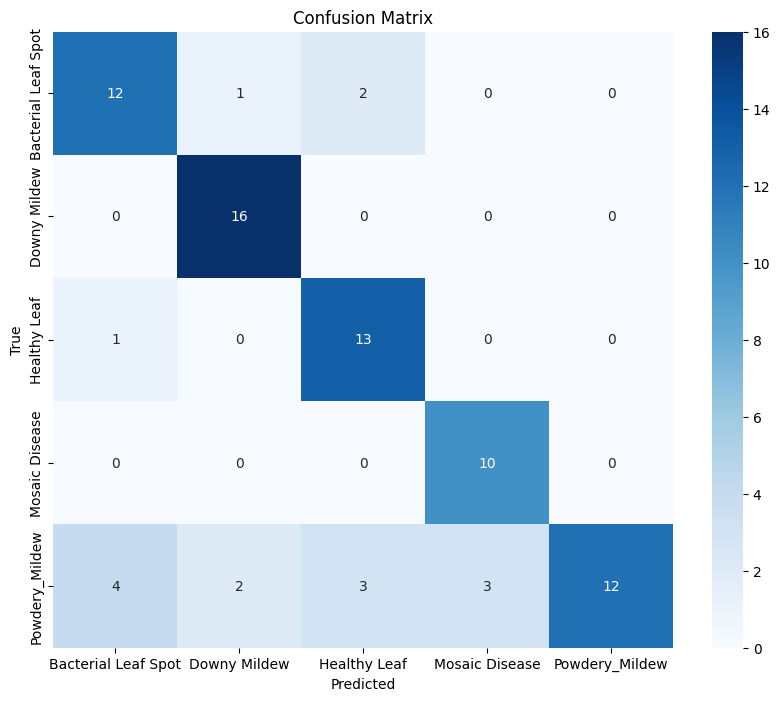

In [25]:
# Calculate and print additional metrics
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

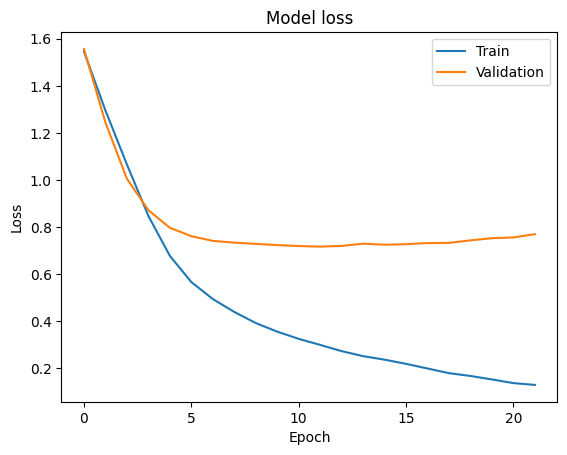

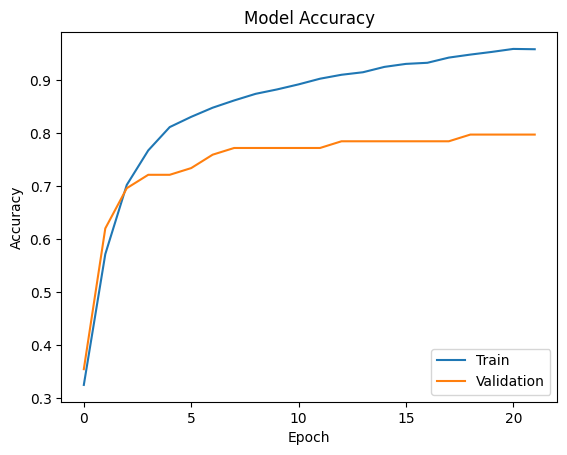

In [26]:

# Plotting the training and testing loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# plot the accuracy of training and validation

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()